In [43]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.morphology import watershed, dilation
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift

plt.rcParams['figure.figsize'] = (10.0, 5.0)
pd.options.display.max_rows = 4000

In [44]:
# Helper functions
def contrast_stretch(I):
    I = I.astype('int32')
    values = [pixel[0] for row in I for pixel in row]
    min_old = min(values)
    max_old = max(values)
    min_new = 0
    max_new = 255
    stretched = (I - min_old) * ((max_new - min_new) / (max_old - min_old)) + min_new
    return stretched.astype('uint8')

def otsu_threshold(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(img_grey)
    img_array = img_grey > thresh
    return img_array

def greyscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def histogram(I):
    hist = [0] * 256
    for row in I:
        for pixel in row:
            hist[pixel[0]] += 1
    plt.bar(range(len(hist)), hist, 5)
    return hist

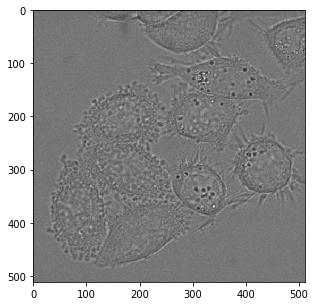

In [45]:
path = 'DIC-C2DH-HeLa/Sequence 1/t002.tif'
img = cv2.imread(path)
plt.imshow(img)

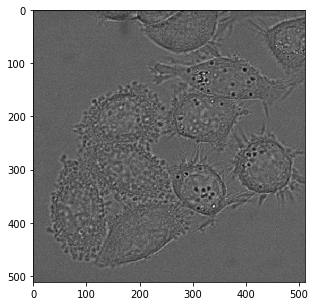

In [128]:
# Normalise original image
norm = None
norm = cv2.normalize(img, norm, 0, 255, cv2.NORM_MINMAX)
plt.imshow(norm)

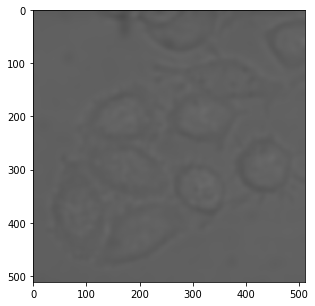

In [129]:
# Smooth image to remove noise
blur = cv2.GaussianBlur(norm, (35,35), 0)
plt.imshow(blur)

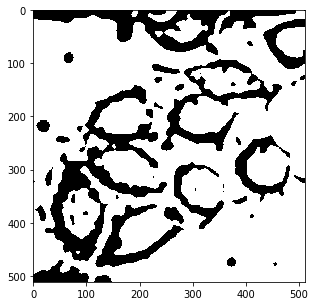

In [130]:
otsu = otsu_threshold(blur)
plt.imshow(otsu, cmap='gray')

In [132]:
# Convert to uint8 for erosion/dilation
otsu = otsu.astype(np.uint8)

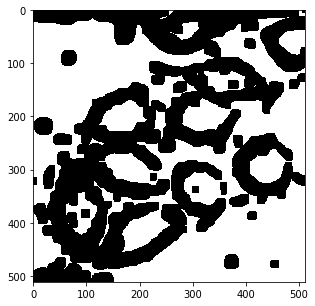

In [134]:
# Choose number of erosions to apply and structuring element size
erosions = 1
struct_size = 11

dil = otsu
for i in range(erosions):
    dil = cv2.erode(dil, np.ones((struct_size,struct_size), np.uint8))
plt.imshow(dil, cmap='gray')

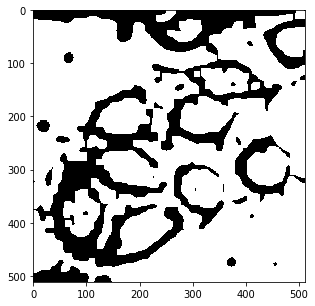

In [135]:
# Choose number of dilations to apply and structuring element size
dilations = 1
struct_size = 11

ero = dil
for i in range(dilations):
    ero = cv2.dilate(ero, np.ones((struct_size,struct_size), np.uint8))
plt.imshow(ero, cmap='gray')

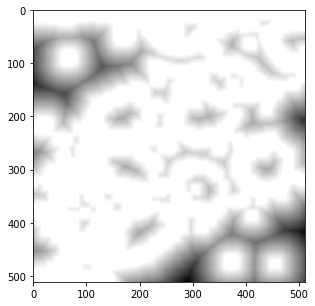

In [126]:
# Perform watershed
input_img = ero

# Get markers
distance = ndi.distance_transform_edt(input_img)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((25,25)), labels=input_img)
markers = ndi.label(local_maxi)[0]

# Show distance
plt.imshow(-distance, cmap='gray')

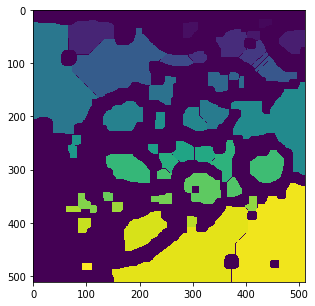

In [127]:
# Apply watershed 
ws_labels = watershed(-distance, markers, mask=input_img, watershed_line=True)
plt.imshow(ws_labels)